In [1]:
from langchain_community.tools import ArxivQueryRun,WikipediaQueryRun
from langchain_community.utilities import WikipediaAPIWrapper,ArxivAPIWrapper

In [2]:
api_wrapper_arxiv=ArxivAPIWrapper(top_k_results=2,doc_content_chars_max=500)
arxiv=ArxivQueryRun(api_wrapper=api_wrapper_arxiv)
print(arxiv.name)

arxiv


In [3]:
arxiv.invoke("Attention iss all you need")

"Published: 2024-07-22\nTitle: Attention Is All You Need But You Don't Need All Of It For Inference of Large Language Models\nAuthors: Georgy Tyukin, Gbetondji J-S Dovonon, Jean Kaddour, Pasquale Minervini\nSummary: The inference demand for LLMs has skyrocketed in recent months, and serving\nmodels with low latencies remains challenging due to the quadratic input length\ncomplexity of the attention layers. In this work, we investigate the effect of\ndropping MLP and attention layers at inference time o"

In [4]:
api_wrapper_wiki=WikipediaAPIWrapper(top_k_results=1,doc_content_chars_max=500)
wiki=WikipediaQueryRun(api_wrapper=api_wrapper_wiki)
wiki.name

'wikipedia'

In [5]:
wiki.invoke("What is machine learning")

'Page: Machine learning\nSummary: Machine learning (ML) is a field of study in artificial intelligence concerned with the development and study of statistical algorithms that can learn from data and generalise to unseen data, and thus perform tasks without explicit instructions. Within a subdiscipline in machine learning, advances in the field of deep learning have allowed neural networks, a class of statistical algorithms, to surpass many previous machine learning approaches in performance.\nML fi'

In [6]:
from dotenv import load_dotenv
load_dotenv()

import os

os.environ["TAVILY_API_KEY"]=os.getenv("TAVILY_API_KEY")
os.environ["GROQ_API_KEY"]=os.getenv("GROQ_API_KEY")
os.environ["LANGCHAIN_API_KEY"]=os.getenv("LANGCHAIN_API_KEY")
os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_PROJECT"]="ReAct-agent"


In [7]:
### Custom Functions
def multiply(a: int, b: int) -> int:
    """Multiply a and b.

    Args:
        a: first int
        b: second int
    """
    return a * b

# This will be a tool
def add(a: int, b: int) -> int:
    """Adds a and b.

    Args:
        a: first int
        b: second int
    """
    return a + b

def divide(a: int, b: int) -> float:
    """Divide a and b.

    Args:
        a: first int
        b: second int
    """
    return a / b

tools=[arxiv,wiki,add,multiply,divide]

In [8]:
### Tavily Search Tool
from langchain_community.tools.tavily_search import TavilySearchResults

tavily = TavilySearchResults()

/var/folders/sw/q0vghxyj0cs6_3glp9q55pq80000gp/T/ipykernel_77094/3584238.py:4: LangChainDeprecationWarning: The class `TavilySearchResults` was deprecated in LangChain 0.3.25 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-tavily package and should be used instead. To use it run `pip install -U :class:`~langchain-tavily` and import as `from :class:`~langchain_tavily import TavilySearch``.
  tavily = TavilySearchResults()


In [9]:
tavily.invoke("Provide me the recent AI news for march 3rd 2025")

[{'title': 'Top 5 AI trends in March 2025: AI agents, smarter supply ...',
  'url': 'https://www.neudesic.com/blog/top-5-ai-trends-march-2025/',
  'content': 'March 2025 has brought a fresh wave of AI innovations that go beyond theoretical breakthroughs and translate directly into real-world impact. From OpenAI’s newly released tools for building AI agents to Microsoft’s external knowledge integration approach, this month’s highlights underscore how artificial intelligence is evolving in ways that matter today, not just tomorrow. Whether it’s optimizing supply chains, pushing the limits of robotics, or making AI systems smarter and more trustworthy, [...] Below, we delve into five top AI trends from March 2025 and explore the practical ways they’re changing industries—from retail to robotics—and setting the stage for what’s ahead. \n\n## 1. OpenAI Releases New Tools for Building AI Agents [...] natural way in a variety of domains.  The investment in physical AI, like Gemini Robotics, h

In [12]:
## Initialize my LLM model

from langchain_groq import ChatGroq

llm=ChatGroq(model="gemma2-9b-it")

llm_with_tools=llm.bind_tools(tools)

In [13]:
from pprint import pprint
from langchain_core.messages import AIMessage, HumanMessage
llm_with_tools.invoke([HumanMessage(content=f"What is the recent AI News")])

AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'mnj9vdwez', 'function': {'arguments': '{"query":"Recent AI news"}', 'name': 'wikipedia'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 82, 'prompt_tokens': 1558, 'total_tokens': 1640, 'completion_time': 0.149090909, 'prompt_time': 0.035147777, 'queue_time': 0.252966722, 'total_time': 0.184238686}, 'model_name': 'gemma2-9b-it', 'system_fingerprint': 'fp_10c08bf97d', 'service_tier': 'on_demand', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--5622e061-3cca-41fb-8182-8e2ec012f876-0', tool_calls=[{'name': 'wikipedia', 'args': {'query': 'Recent AI news'}, 'id': 'mnj9vdwez', 'type': 'tool_call'}], usage_metadata={'input_tokens': 1558, 'output_tokens': 82, 'total_tokens': 1640})

In [14]:
llm_with_tools.invoke([HumanMessage(content=f"What is the recent AI News")]).tool_calls

[{'name': 'wikipedia',
  'args': {'query': 'Recent AI News'},
  'id': '47tjabzd3',
  'type': 'tool_call'}]

In [15]:
## State Schema
from typing_extensions import TypedDict
from langchain_core.messages import AnyMessage
from typing import Annotated
from langgraph.graph.message import add_messages
class State(TypedDict):
    messages:Annotated[list[AnyMessage],add_messages]

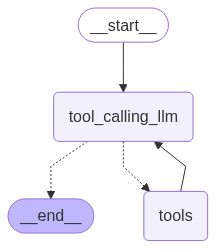

In [16]:
### Entire Chatbot With LangGraph
from IPython.display import Image, display
from langgraph.graph import StateGraph, START, END
from langgraph.prebuilt import ToolNode
from langgraph.prebuilt import tools_condition

### Node definition
def tool_calling_llm(state:State):
    return {"messages":[llm_with_tools.invoke(state["messages"])]}

# Build graph
builder = StateGraph(State)
builder.add_node("tool_calling_llm", tool_calling_llm)
builder.add_node("tools", ToolNode(tools))

builder.add_edge(START, "tool_calling_llm")
builder.add_conditional_edges(
    "tool_calling_llm",
    # If the latest message (result) from assistant is a tool call -> tools_condition routes to tools
    # If the latest message (result) from assistant is a not a tool call -> tools_condition routes to END
    tools_condition,
)
builder.add_edge("tools","tool_calling_llm")


graph = builder.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))


In [17]:
messages=graph.invoke({"messages":HumanMessage(content="Provide me the top 10 recent AI news for MArch 3rd 2025,add 5 plus 5 and then multiply by 10")})
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

Provide me the top 10 recent AI news for MArch 3rd 2025,add 5 plus 5 and then multiply by 10
================================== Ai Message ==================================
Tool Calls:
  wikipedia (smnws1spb)
 Call ID: smnws1spb
  Args:
    query: Recent AI news March 3rd 2025
================================= Tool Message =================================
Name: wikipedia

Page: OpenAI
Summary: OpenAI, Inc. is an American artificial intelligence (AI) organization headquartered in San Francisco, California. It aims to develop "safe and beneficial" artificial general intelligence (AGI), which it defines as "highly autonomous systems that outperform humans at most economically valuable work". As a leading organization in the ongoing AI boom, OpenAI is known for the GPT family of large language models, the DALL-E series of text-to-image models, and a text-to-video mod
================================== Ai Me

In [18]:
messages=graph.invoke({"messages":HumanMessage(content="What is machine learning")})
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

What is machine learning
================================== Ai Message ==================================
Tool Calls:
  wikipedia (7kgk490e9)
 Call ID: 7kgk490e9
  Args:
    query: machine learning
================================= Tool Message =================================
Name: wikipedia

Page: Machine learning
Summary: Machine learning (ML) is a field of study in artificial intelligence concerned with the development and study of statistical algorithms that can learn from data and generalise to unseen data, and thus perform tasks without explicit instructions. Within a subdiscipline in machine learning, advances in the field of deep learning have allowed neural networks, a class of statistical algorithms, to surpass many previous machine learning approaches in performance.
ML fi
================================== Ai Message ==================================

Machine learning (ML) is a field of stu

AGENT MEMORY

In [19]:
messages=graph.invoke({"messages":HumanMessage(content="What is 5 plus 8")})
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

What is 5 plus 8
================================== Ai Message ==================================
Tool Calls:
  add (69jr31q4e)
 Call ID: 69jr31q4e
  Args:
    a: 5
    b: 8
================================= Tool Message =================================
Name: add

13
================================== Ai Message ==================================

13


In [20]:
messages=[HumanMessage(content="Divide that by 5")]
messages=graph.invoke({"messages":messages})
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

Divide that by 5
================================== Ai Message ==================================

```json
Tool Calls:
  divide (4s79jmkwr)
 Call ID: 4s79jmkwr
  Args:
    a: 10
    b: 2
================================= Tool Message =================================
Name: divide

5.0
================================== Ai Message ==================================
Tool Calls:
  multiply (j6wemtp34)
 Call ID: j6wemtp34
  Args:
    a: 5
    b: 2
================================= Tool Message =================================
Name: multiply

10
================================== Ai Message ==================================

The answer is 10


In [21]:
### Entire Chatbot With LangGraph
from IPython.display import Image, display
from langgraph.graph import StateGraph, START, END
from langgraph.prebuilt import ToolNode
from langgraph.prebuilt import tools_condition

### Node definition
def tool_calling_llm(state:State):
    return {"messages":[llm_with_tools.invoke(state["messages"])]}

# Build graph
builder = StateGraph(State)
builder.add_node("tool_calling_llm", tool_calling_llm)
builder.add_node("tools", ToolNode(tools))

builder.add_edge(START, "tool_calling_llm")
builder.add_conditional_edges(
    "tool_calling_llm",
    # If the latest message (result) from assistant is a tool call -> tools_condition routes to tools
    # If the latest message (result) from assistant is a not a tool call -> tools_condition routes to END
    tools_condition,
)
builder.add_edge("tools","tool_calling_llm")




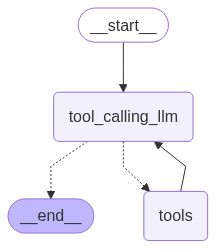

In [22]:
from langgraph.checkpoint.memory import MemorySaver
memory=MemorySaver()
graph_memory = builder.compile(checkpointer=memory)

# View
display(Image(graph_memory.get_graph().draw_mermaid_png()))

In [23]:
## Specify the thread

config={"configurable":{"thread_id":"1"}}
# Specify an input
messages = [HumanMessage(content="Add 12 and 13.")]
messages=graph_memory.invoke({"messages":messages},config=config)
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

Add 12 and 13.
================================== Ai Message ==================================
Tool Calls:
  add (tq1sed9pc)
 Call ID: tq1sed9pc
  Args:
    a: 12
    b: 13
================================= Tool Message =================================
Name: add

25
================================== Ai Message ==================================

25


In [24]:
messages = [HumanMessage(content="add that number to 25")]
messages=graph_memory.invoke({"messages":messages},config=config)
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

Add 12 and 13.
================================== Ai Message ==================================
Tool Calls:
  add (tq1sed9pc)
 Call ID: tq1sed9pc
  Args:
    a: 12
    b: 13
================================= Tool Message =================================
Name: add

25
================================== Ai Message ==================================

25
================================ Human Message =================================

add that number to 25
================================== Ai Message ==================================
Tool Calls:
  add (s0tzgwrtw)
 Call ID: s0tzgwrtw
  Args:
    a: 50
    b: 25
================================= Tool Message =================================
Name: add

75
================================== Ai Message ==================================

75
